In [1]:
#general imports
import numpy as np
import pandas as pd


import unicodedata
import string
import re

#sklearn imports
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#nltk imports
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer

np.set_printoptions(linewidth=100)

sw = stopwords.words('english')
pt = string.punctuation
stemmer = SnowballStemmer('english')

## load data and drop image columns

In [2]:
df = pd.read_csv('data/skincare.csv')
df = df.reset_index(drop=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop(['Unnamed: 0.1'], axis=1, inplace=True);
df.head()

,Category,UserName,Product,UserReviewTitle,Url,Brand,ReviewText,Rank,OverallScore,Featured,UserRating,Date,ReviewTextMore,Image
0,More Anti-Aging,pynkNymphette,Elemis Pro-Collagen Marine Cream,$$$$$$,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,Crrrraaazzzyyyy expensive! But it works so gre...,1.0,9.3,1.0,8.0,"— 6 years, 2 months ago",NaN,http://images.totalbeauty.com/uploads/tx_userp...
1,More Anti-Aging,corina,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,WOW . . . .this is a really good product. I fi...,2.0,9.3,0.0,10.0,"— 3 years, 11 months ago","people noticed, which is huge for me. I'm defi...",http://images.totalbeauty.com/uploads/tx_userp...
2,More Anti-Aging,Kathrina,Elemis Pro-Collagen Marine Cream,Good but pricey,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,I started using the Elemis line about 6 months...,3.0,9.3,0.0,10.0,"— 9 years, 2 months ago","ot recommend it for very dry skin though, it i...",http://images.totalbeauty.com/uploads/tx_userp...
3,More Anti-Aging,alicia_acedo,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,"I had a complete facial, on a Carnival cruise ...",4.0,9.3,0.0,10.0,"— 3 years, 5 months ago",NaN,http://images.totalbeauty.com/uploads/tx_userp...
4,More Anti-Aging,sonia_silveroli,Elemis Pro-Collagen Marine Cream,Like Silk,/reviews/product/503745/elemis-procollagen-mar...,Elemis Product Reviews,"I purchased this a few years ago and WOW, just...",5.0,9.3,0.0,10.0,"— 5 years, 5 months ago",NaN,http://images.totalbeauty.com/uploads/tx_userp...


In [3]:
df.drop(['Image'], axis=1, inplace=True);

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60690 entries, 0 to 60689
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         60690 non-null  object 
 1   UserName         52032 non-null  object 
 2   Product          60690 non-null  object 
 3   UserReviewTitle  52032 non-null  object 
 4   Url              60690 non-null  object 
 5   Brand            60690 non-null  object 
 6   ReviewText       52031 non-null  object 
 7   Rank             52032 non-null  float64
 8   OverallScore     52032 non-null  float64
 9   Featured         52032 non-null  float64
 10  UserRating       52032 non-null  float64
 11  Date             52032 non-null  object 
 12  ReviewTextMore   7965 non-null   object 
dtypes: float64(4), object(9)
memory usage: 6.0+ MB


In [5]:
df.Category.nunique()

22

In [6]:
#reduce datafame for ease of use
skindf = df.drop(['UserReviewTitle', 'Url'], axis=1);
skindf.head()

,Category,UserName,Product,Brand,ReviewText,Rank,OverallScore,Featured,UserRating,Date,ReviewTextMore
0,More Anti-Aging,pynkNymphette,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,Crrrraaazzzyyyy expensive! But it works so gre...,1.0,9.3,1.0,8.0,"— 6 years, 2 months ago",NaN
1,More Anti-Aging,corina,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,WOW . . . .this is a really good product. I fi...,2.0,9.3,0.0,10.0,"— 3 years, 11 months ago","people noticed, which is huge for me. I'm defi..."
2,More Anti-Aging,Kathrina,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,I started using the Elemis line about 6 months...,3.0,9.3,0.0,10.0,"— 9 years, 2 months ago","ot recommend it for very dry skin though, it i..."
3,More Anti-Aging,alicia_acedo,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,"I had a complete facial, on a Carnival cruise ...",4.0,9.3,0.0,10.0,"— 3 years, 5 months ago",NaN
4,More Anti-Aging,sonia_silveroli,Elemis Pro-Collagen Marine Cream,Elemis Product Reviews,"I purchased this a few years ago and WOW, just...",5.0,9.3,0.0,10.0,"— 5 years, 5 months ago",NaN


## Original Dataframe EDA & Basic Metrics

In [7]:
#how many unique products & unique users
users_count = df['UserName'].nunique()
products_count = df['Product'].nunique();
category_count = df['Category'].nunique();
print(f'Total number of users: {users_count}.  Total number of products: {products_count}.  Total number of categories: {category_count}')

Total number of users: 24071.  Total number of products: 14854.  Total number of categories: 22


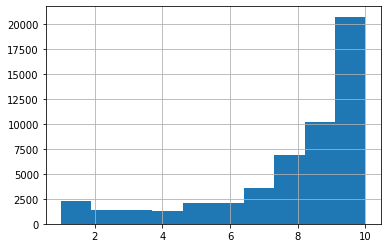

In [8]:
#histogram of user ratings
df['UserRating'].hist();

In [9]:
category = df.Category.value_counts()
category

More Moisturizer                       12034
More Cleanser                          10950
More Anti-Aging                         7014
More Eye Treatments                     4190
More Blemish + Acne Control             3923
More Masks, Peels                       3083
More Exfoliators, Scrubs                3055
More Makeup Remover                     2625
More Toners, Astringents                2219
More Night Cream                        2085
More Sun Protection                     1552
More Self Tanners                       1324
More Tools + Appliances                 1319
More Toothpaste + Breath Freshener      1262
More Lip Plumper                         956
More Oral Care                           649
More Dermatology Treatments & Peels      631
More Lightening Cream                    610
More Ingestibles + Supplements           513
More Microdermabrasion                   410
More Lip Exfoliant                       284
More                                       2
Name: Cate

## Make skincare dataframe for reduced scope

In [10]:
#make skincare dataframe for more specific recommender

In [11]:
skindf = df.query('Category == ["More Moisturizer","More Cleanser","More Anti-Aging","More Eye Treatments","More Blemish + Acne Control","More Masks, Peels, More Exfoliators, Scrubs","More Toners, Astringents","More Night Cream","More Sun Protection"]')
skindf.info()
#for now leave in unrated products

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43967 entries, 0 to 60689
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         43967 non-null  object 
 1   UserName         37760 non-null  object 
 2   Product          43967 non-null  object 
 3   UserReviewTitle  37760 non-null  object 
 4   Url              43967 non-null  object 
 5   Brand            43967 non-null  object 
 6   ReviewText       37760 non-null  object 
 7   Rank             37760 non-null  float64
 8   OverallScore     37760 non-null  float64
 9   Featured         37760 non-null  float64
 10  UserRating       37760 non-null  float64
 11  Date             37760 non-null  object 
 12  ReviewTextMore   5922 non-null   object 
dtypes: float64(4), object(9)
memory usage: 4.7+ MB


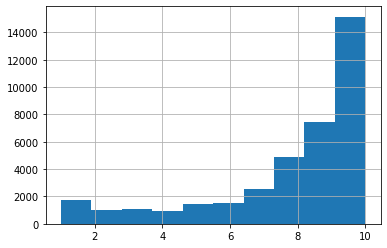

In [12]:
#histogram of user ratings
skindf['UserRating'].hist();

In [13]:
category_list = ["More Moisturizer","More Cleanser","More Anti-Aging","More Eye Treatments","More Blemish + Acne Control","More Masks, Peels, More Exfoliators, Scrubs","More Toners, Astringents","More Night Cream","More Sun Protection"]

In [14]:
skindf.Category.value_counts()

More Moisturizer               12034
More Cleanser                  10950
More Anti-Aging                 7014
More Eye Treatments             4190
More Blemish + Acne Control     3923
More Toners, Astringents        2219
More Night Cream                2085
More Sun Protection             1552
Name: Category, dtype: int64

In [15]:
#skindf.iloc[:4, 1]
#skindf.loc[:,'Category']

In [16]:
skindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43967 entries, 0 to 60689
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         43967 non-null  object 
 1   UserName         37760 non-null  object 
 2   Product          43967 non-null  object 
 3   UserReviewTitle  37760 non-null  object 
 4   Url              43967 non-null  object 
 5   Brand            43967 non-null  object 
 6   ReviewText       37760 non-null  object 
 7   Rank             37760 non-null  float64
 8   OverallScore     37760 non-null  float64
 9   Featured         37760 non-null  float64
 10  UserRating       37760 non-null  float64
 11  Date             37760 non-null  object 
 12  ReviewTextMore   5922 non-null   object 
dtypes: float64(4), object(9)
memory usage: 4.7+ MB


In [17]:
skindf = skindf[skindf['UserName'].notnull()]
skindf.drop(['Url'], axis=1, inplace=True);
skindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37760 entries, 0 to 51988
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         37760 non-null  object 
 1   UserName         37760 non-null  object 
 2   Product          37760 non-null  object 
 3   UserReviewTitle  37760 non-null  object 
 4   Brand            37760 non-null  object 
 5   ReviewText       37760 non-null  object 
 6   Rank             37760 non-null  float64
 7   OverallScore     37760 non-null  float64
 8   Featured         37760 non-null  float64
 9   UserRating       37760 non-null  float64
 10  Date             37760 non-null  object 
 11  ReviewTextMore   5922 non-null   object 
dtypes: float64(4), object(8)
memory usage: 3.7+ MB


## Content Based Recommender

In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 8] nodename nor servname provided, or not
[nltk_data]     known>


False

In [19]:
skindf['ReviewText'].head()

0    Crrrraaazzzyyyy expensive! But it works so gre...
1    WOW . . . .this is a really good product. I fi...
2    I started using the Elemis line about 6 months...
3    I had a complete facial, on a Carnival cruise ...
4    I purchased this a few years ago and WOW, just...
Name: ReviewText, dtype: object

### cleaning review text to capture good tagging words

In [20]:
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()


In [21]:
con_df = skindf;
con_df.head()

,Category,UserName,Product,UserReviewTitle,Brand,ReviewText,Rank,OverallScore,Featured,UserRating,Date,ReviewTextMore
0,More Anti-Aging,pynkNymphette,Elemis Pro-Collagen Marine Cream,$$$$$$,Elemis Product Reviews,Crrrraaazzzyyyy expensive! But it works so gre...,1.0,9.3,1.0,8.0,"— 6 years, 2 months ago",NaN
1,More Anti-Aging,corina,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,Elemis Product Reviews,WOW . . . .this is a really good product. I fi...,2.0,9.3,0.0,10.0,"— 3 years, 11 months ago","people noticed, which is huge for me. I'm defi..."
2,More Anti-Aging,Kathrina,Elemis Pro-Collagen Marine Cream,Good but pricey,Elemis Product Reviews,I started using the Elemis line about 6 months...,3.0,9.3,0.0,10.0,"— 9 years, 2 months ago","ot recommend it for very dry skin though, it i..."
3,More Anti-Aging,alicia_acedo,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,Elemis Product Reviews,"I had a complete facial, on a Carnival cruise ...",4.0,9.3,0.0,10.0,"— 3 years, 5 months ago",NaN
4,More Anti-Aging,sonia_silveroli,Elemis Pro-Collagen Marine Cream,Like Silk,Elemis Product Reviews,"I purchased this a few years ago and WOW, just...",5.0,9.3,0.0,10.0,"— 5 years, 5 months ago",NaN


In [22]:
def stop_word_remover(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2

In [23]:
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text) 
    text = text.replace("nbsp", "")
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if stop_word_remover(word)]
    clean_text2 = [word for word in clean_text if stop_word_remover(word)]
    return " ".join(clean_text2)

In [24]:
## combine review text and more revivew text for extra power for vocabulary

con_df['FullReviewText'] = con_df['ReviewText'].str.cat(con_df['ReviewTextMore'],sep=" ")
con_df.head()

,Category,UserName,Product,UserReviewTitle,Brand,ReviewText,Rank,OverallScore,Featured,UserRating,Date,ReviewTextMore,FullReviewText
0,More Anti-Aging,pynkNymphette,Elemis Pro-Collagen Marine Cream,$$$$$$,Elemis Product Reviews,Crrrraaazzzyyyy expensive! But it works so gre...,1.0,9.3,1.0,8.0,"— 6 years, 2 months ago",NaN,NaN
1,More Anti-Aging,corina,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,Elemis Product Reviews,WOW . . . .this is a really good product. I fi...,2.0,9.3,0.0,10.0,"— 3 years, 11 months ago","people noticed, which is huge for me. I'm defi...",WOW . . . .this is a really good product. I fi...
2,More Anti-Aging,Kathrina,Elemis Pro-Collagen Marine Cream,Good but pricey,Elemis Product Reviews,I started using the Elemis line about 6 months...,3.0,9.3,0.0,10.0,"— 9 years, 2 months ago","ot recommend it for very dry skin though, it i...",I started using the Elemis line about 6 months...
3,More Anti-Aging,alicia_acedo,Elemis Pro-Collagen Marine Cream,Elemis Pro Collagen Marine Cream,Elemis Product Reviews,"I had a complete facial, on a Carnival cruise ...",4.0,9.3,0.0,10.0,"— 3 years, 5 months ago",NaN,NaN
4,More Anti-Aging,sonia_silveroli,Elemis Pro-Collagen Marine Cream,Like Silk,Elemis Product Reviews,"I purchased this a few years ago and WOW, just...",5.0,9.3,0.0,10.0,"— 5 years, 5 months ago",NaN,NaN


In [25]:
# apply text cleaning
con_df['ReviewText'] = con_df['ReviewText'].apply(clean_txt)

In [26]:
con_df['ReviewText'].head()

0    crrrraaazzzyyyy expensive work great like use ...
1    wow really good product first learn website de...
2    start use elemis line months ago slowly start ...
3    complete facial carnival cruise months ago pur...
4    purchase years ago wow smooth totally dissolve...
Name: ReviewText, dtype: object

In [27]:
con_df.columns

Index(['Category', 'UserName', 'Product', 'UserReviewTitle', 'Brand',
       'ReviewText', 'Rank', 'OverallScore', 'Featured', 'UserRating', 'Date',
       'ReviewTextMore', 'FullReviewText'],
      dtype='object')

In [28]:
con_df.drop(['UserName','UserReviewTitle','Rank', 'Featured','Brand', 'Date', 'ReviewTextMore', 'FullReviewText', 'OverallScore'],axis=1, inplace=True);
con_df

,Category,Product,ReviewText,UserRating
0,More Anti-Aging,Elemis Pro-Collagen Marine Cream,crrrraaazzzyyyy expensive work great like use ...,8.0
1,More Anti-Aging,Elemis Pro-Collagen Marine Cream,wow really good product first learn website de...,10.0
2,More Anti-Aging,Elemis Pro-Collagen Marine Cream,start use elemis line months ago slowly start ...,10.0
3,More Anti-Aging,Elemis Pro-Collagen Marine Cream,complete facial carnival cruise months ago pur...,10.0
4,More Anti-Aging,Elemis Pro-Collagen Marine Cream,purchase years ago wow smooth totally dissolve...,10.0
...,...,...,...,...
51773,More Cleanser,Proactiv Renewing Cleanser,use everday like instructions say see result d...,10.0
51774,More Cleanser,Proactiv Renewing Cleanser,part three step program work amazingly well ge...,9.0
51808,More Cleanser,BeautyRx by Dr. Schultz Balancing Glycolic Cle...,glycolic acid cleanser felt really gentle flip...,7.0
51873,More Moisturizer,Dr. Jart+ Water Drop Hydrating Moisturizer,really interest product come tube gel balm tex...,8.0


In [29]:
con_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37760 entries, 0 to 51988
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Category    37760 non-null  object 
 1   Product     37760 non-null  object 
 2   ReviewText  37760 non-null  object 
 3   UserRating  37760 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.4+ MB



### Update dataframe to be singular products with total review text as document

In [30]:
con_df['Product'].value_counts()

Olay Complete All Day Moisturizer with Sunscreen Broad Spectrum SPF 15 - Normal    1224
Olay Regenerist Regenerating Serum                                                  720
Nu Skin AgeLoc Future Serum                                                         539
Philosophy Purity Made Simple Foaming 3-in-1 Cleansing Gel for Face and Eyes        530
Olay 4-in-1 Daily Facial Cloths - Normal Skin                                       486
                                                                                   ... 
Zirh Age Defying Duo                                                                  1
Paula's Choice Resist Anti-Aging Eye Cream                                            1
Laboratorie Remede HydraTherapy Lift Intense Serum                                    1
Olay Age Defying 2-in-1 Anti-Wrinkle Day Cream + Serum                                1
My Blend Early Age Alert Day MiniLab Lotion                                           1
Name: Product, Length: 4621, dty

In [31]:
con_df['Helper'] = np.where(con_df['Product'] == '', 0, 1)

In [32]:
con_df.Helper.value_counts()

1    37760
Name: Helper, dtype: int64

In [33]:
con_df.drop(['Helper'],axis=1, inplace=True);
con_df.head()

,Category,Product,ReviewText,UserRating
0,More Anti-Aging,Elemis Pro-Collagen Marine Cream,crrrraaazzzyyyy expensive work great like use ...,8.0
1,More Anti-Aging,Elemis Pro-Collagen Marine Cream,wow really good product first learn website de...,10.0
2,More Anti-Aging,Elemis Pro-Collagen Marine Cream,start use elemis line months ago slowly start ...,10.0
3,More Anti-Aging,Elemis Pro-Collagen Marine Cream,complete facial carnival cruise months ago pur...,10.0
4,More Anti-Aging,Elemis Pro-Collagen Marine Cream,purchase years ago wow smooth totally dissolve...,10.0


In [34]:
con_df.sample(frac=1)

,Category,Product,ReviewText,UserRating
48203,More Blemish + Acne Control,Murad Acne Spot Treatment,stuff work best zits start form turn white fla...,7.0
18431,More Moisturizer,Lumene Vitamin C+ Energy Cocktail Intensive Care,dry skin treatment way oily doesnt work well m...,3.0
10691,More Moisturizer,Mary Kay Velocity Lightweight Moisturizer,lightweight thick never worry face dry point day,10.0
464,More Moisturizer,First Aid Beauty Ultra Repair Cream,pleasantly surprise light cream feel despite c...,9.0
6519,More Cleanser,Olay Total Effects Wet Cleansing Cloths,love wipe hurry easily take make leave skin fe...,9.0
...,...,...,...,...
36266,More Cleanser,Olay Pore Minimizing Cleanser + Scrub,crazy like hate think would harsh actually rea...,8.0
25547,More Sun Protection,Vanicream Sunscreen Sensitive Skin SPF 60,prop use parabens whatsoever offer product tha...,10.0
18252,More Moisturizer,YonKa Creme 15 - Purifying Treatment For Probl...,nice cream prevent help clear breakouts,10.0
10199,More Moisturizer,Olay Complete All Day Moisturizer with Sunscre...,use oil olay years skin soft keep way seventy ...,10.0


In [35]:
lets_see = con_df.groupby(["Product","Category"])['UserRating'].mean()
lets_see

Product                                                                 Category           
1 Day Acuvue Brand Contact Lenses                                       More Eye Treatments     7.750000
1 Day Acuvue Moist Brand Contact Lenses                                 More Eye Treatments     8.200000
100% Pure Aqua Boost Hydrating Mask                                     More Moisturizer       10.000000
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30                 More Moisturizer        8.000000
100% Pure Korres White Tea Facial Fluid Gel Cleanser                    More Cleanser           7.000000
                                                                                                 ...    
mark Let's Be Clear Blemish Neutralizing Cleanser For Misbehaving Skin  More Cleanser           5.000000
no!no! FaceTrainer                                                      More Anti-Aging         9.000000
pur-lisse pur~protect spf 30                                        

In [36]:
ratings = lets_see.to_frame()
ratings

,,UserRating
Product,Category,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.750000
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.200000
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.000000
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.000000
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,7.000000
...,...,...
mark Let's Be Clear Blemish Neutralizing Cleanser For Misbehaving Skin,More Cleanser,5.000000
no!no! FaceTrainer,More Anti-Aging,9.000000
pur-lisse pur~protect spf 30,More Sun Protection,8.400000


In [37]:
newtestseries = con_df.groupby(["Product","Category"])['ReviewText'].apply(list)

In [38]:
newtestdf = newtestseries.to_frame();
newtestdf

,,ReviewText
Product,Category,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,[try different brand husband remain loyal john...
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,[really love acuvue contact help see better ea...
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,[kind face mask cream freak test lot different...
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,[pure argan oil hydration facial moisturizer s...
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,[love cleanser normal dry skin use product ski...
...,...,...
mark Let's Be Clear Blemish Neutralizing Cleanser For Misbehaving Skin,More Cleanser,[use product couple time okay really need dry ...
no!no! FaceTrainer,More Anti-Aging,[ive try days get use weird look kid couldnt s...
pur-lisse pur~protect spf 30,More Sun Protection,[receive sample decide use today pleasantly su...


In [39]:
newtestdf = pd.concat([newtestdf, ratings], axis=1);
newtestdf

,,ReviewText,UserRating
Product,Category,,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,[try different brand husband remain loyal john...,7.750000
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,[really love acuvue contact help see better ea...,8.200000
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,[kind face mask cream freak test lot different...,10.000000
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,[pure argan oil hydration facial moisturizer s...,8.000000
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,[love cleanser normal dry skin use product ski...,7.000000
...,...,...,...
mark Let's Be Clear Blemish Neutralizing Cleanser For Misbehaving Skin,More Cleanser,[use product couple time okay really need dry ...,5.000000
no!no! FaceTrainer,More Anti-Aging,[ive try days get use weird look kid couldnt s...,9.000000
pur-lisse pur~protect spf 30,More Sun Protection,[receive sample decide use today pleasantly su...,8.400000


In [40]:

newtestdf.reset_index()

,Product,Category,ReviewText,UserRating
0,1 Day Acuvue Brand Contact Lenses,More Eye Treatments,[try different brand husband remain loyal john...,7.750000
1,1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,[really love acuvue contact help see better ea...,8.200000
2,100% Pure Aqua Boost Hydrating Mask,More Moisturizer,[kind face mask cream freak test lot different...,10.000000
3,100% Pure Argan Oil Hydration Facial Moisturiz...,More Moisturizer,[pure argan oil hydration facial moisturizer s...,8.000000
4,100% Pure Korres White Tea Facial Fluid Gel Cl...,More Cleanser,[love cleanser normal dry skin use product ski...,7.000000
...,...,...,...,...
4621,mark Let's Be Clear Blemish Neutralizing Clean...,More Cleanser,[use product couple time okay really need dry ...,5.000000
4622,no!no! FaceTrainer,More Anti-Aging,[ive try days get use weird look kid couldnt s...,9.000000
4623,pur-lisse pur~protect spf 30,More Sun Protection,[receive sample decide use today pleasantly su...,8.400000
4624,pur~lisse pur~delicate gentle soy milk cleanse...,More Cleanser,[face cleanser delicate skin thoroughly clean ...,10.000000


In [41]:
newtestmatrix = newtestdf.ReviewText.values;
newtestmatrix[588]


['nothing happen months apply regularly heavy easily absorb pity expect biotherm']

In [42]:
# test_df = newtestdf.iloc[:20000,:].reset_index();
test_df = newtestdf.iloc[:,:].reset_index();
test_df.head()

,Product,Category,ReviewText,UserRating
0,1 Day Acuvue Brand Contact Lenses,More Eye Treatments,[try different brand husband remain loyal john...,7.75
1,1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,[really love acuvue contact help see better ea...,8.20
2,100% Pure Aqua Boost Hydrating Mask,More Moisturizer,[kind face mask cream freak test lot different...,10.00
3,100% Pure Argan Oil Hydration Facial Moisturiz...,More Moisturizer,[pure argan oil hydration facial moisturizer s...,8.00
4,100% Pure Korres White Tea Facial Fluid Gel Cl...,More Cleanser,[love cleanser normal dry skin use product ski...,7.00


In [43]:
test_df['ReviewText2'] = [','.join(map(str, l)) for l in test_df['ReviewText']];
test_df.head()

,Product,Category,ReviewText,UserRating,ReviewText2
0,1 Day Acuvue Brand Contact Lenses,More Eye Treatments,[try different brand husband remain loyal john...,7.75,try different brand husband remain loyal johns...
1,1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,[really love acuvue contact help see better ea...,8.20,really love acuvue contact help see better eas...
2,100% Pure Aqua Boost Hydrating Mask,More Moisturizer,[kind face mask cream freak test lot different...,10.00,kind face mask cream freak test lot different ...
3,100% Pure Argan Oil Hydration Facial Moisturiz...,More Moisturizer,[pure argan oil hydration facial moisturizer s...,8.00,pure argan oil hydration facial moisturizer sp...
4,100% Pure Korres White Tea Facial Fluid Gel Cl...,More Cleanser,[love cleanser normal dry skin use product ski...,7.00,love cleanser normal dry skin use product skin...


In [44]:
content_df = test_df.drop(['ReviewText'],axis=1)
content_df.set_index(['Product'], inplace=True);
content_df.head()

,Category,UserRating,ReviewText2
Product,,,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.75,try different brand husband remain loyal johns...
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.20,really love acuvue contact help see better eas...
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.00,kind face mask cream freak test lot different ...
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.00,pure argan oil hydration facial moisturizer sp...
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,7.00,love cleanser normal dry skin use product skin...


## Content based item recommender based on like product within data

In [45]:

import pandas as pd
from rake_nltk import Rake
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import re

class ItemRecommender():
    '''
    Content based item recommender
    '''
    def __init__(self, similarity_measure=None):
        self.similarity_matrix = None
        self.item_names = None

        if similarity_measure == None:
            self.similarity_measure = cosine_similarity
        else:
            self.similarity_measure = similarity_measure

    
    def fit(self, X, titles=None):
        '''
        Takes a numpy array of the item attributes and creates the similarity matrix
        INPUT -
            X: NUMPY ARRAY - Rows are items, columns are feature values / or DF
            titles: LIST - List of the item names/titles in order of the numpy arrray
        
        OUTPUT - None
        Notes:  You might want to keep titles and X as attributes to refer to them later
        Create the a similarity matrix of item to item similarity
        '''

        # While keeping this as a sparse matrix would be best the cosign sim
        # function returns a array so there is no reason.
        
        if isinstance(X, pd.DataFrame):
            self.item_counts = X
            self.item_names = X.index
            self.similarity_df = pd.DataFrame(self.similarity_measure(X.values, X.values),
                 index = self.item_names)
        else:
            self.item_counts = X
            self.similarity_df = pd.DataFrame(self.similarity_measure(X, X),
                 index = titles)
            self.item_names = self.similarity_df.index

        
    def get_recommendations(self, item, n=5):
        '''
        Returns the top n items related to the item passed in
        INPUT:
            item    - STRING - Name of item in the original DataFrame 
            n       - INT    - Number of top related items to return 
        OUTPUT:
            items - List of the top n related item names
        For a given item find the n most similar items to it (this can be done using the similarity matrix created in the fit method)
        '''
        return self.item_names[self.similarity_df.loc[item].values.argsort()[-(n+1):-1]].values[::-1]

    


### CountVectorizer

In [46]:
 # instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(content_df['ReviewText2'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(content_df.index)

In [47]:

rec = ItemRecommender()
count_df = pd.DataFrame(count_matrix.todense(), index=indices.values)


In [48]:
rec.fit(count_df)



In [49]:

print(rec.get_recommendations('100% Pure Korres White Tea Facial Fluid Gel Cleanser'))

['Dermalogica Special Cleansing Gel' 'Avalon Organics Vitamin C Refreshing Cleansing Gel'
 'bareMinerals Purifying Facial Cleanser' 'Aveeno Clear Complexion Foaming Cleanser'
 'Aveeno Positively Radiant Cleanser']


### TF-IDF

In [50]:
# instantiating and generating the count matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0)
tfidf_matrix = count.fit_transform(content_df['ReviewText2'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(content_df.index)

In [51]:
rec = ItemRecommender()
count_df = pd.DataFrame(count_matrix.todense(), index=indices.values)


In [52]:
rec.fit(count_df)

In [53]:
print(rec.get_recommendations('100% Pure Korres White Tea Facial Fluid Gel Cleanser'))

['Dermalogica Special Cleansing Gel' 'Avalon Organics Vitamin C Refreshing Cleansing Gel'
 'bareMinerals Purifying Facial Cleanser' 'Aveeno Clear Complexion Foaming Cleanser'
 'Aveeno Positively Radiant Cleanser']


In [54]:
test_df.head()

,Product,Category,ReviewText,UserRating,ReviewText2
0,1 Day Acuvue Brand Contact Lenses,More Eye Treatments,[try different brand husband remain loyal john...,7.75,try different brand husband remain loyal johns...
1,1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,[really love acuvue contact help see better ea...,8.20,really love acuvue contact help see better eas...
2,100% Pure Aqua Boost Hydrating Mask,More Moisturizer,[kind face mask cream freak test lot different...,10.00,kind face mask cream freak test lot different ...
3,100% Pure Argan Oil Hydration Facial Moisturiz...,More Moisturizer,[pure argan oil hydration facial moisturizer s...,8.00,pure argan oil hydration facial moisturizer sp...
4,100% Pure Korres White Tea Facial Fluid Gel Cl...,More Cleanser,[love cleanser normal dry skin use product ski...,7.00,love cleanser normal dry skin use product skin...


In [55]:
reviewtext = test_df.ReviewText.values
reviewtext.shape

(4626,)

In [56]:
#reviewtext[:3]

In [57]:
reviewtext2 = test_df.ReviewText2.values
reviewtext2.shape

(4626,)

In [58]:
#reviewtext2[:3]

In [59]:
#reviewtextlist2 = reviewtext2.tolist()
#reviewtextlist2[:3]

In [60]:
reviewtextlist = reviewtext.tolist()
reviewtextlist[:3]

[['try different brand husband remain loyal johnson johnson day acuvue contact lenses like convenient maintenance free comfortable switch acuvue moist years ago even conformable however contact lenses expensive others',
  'fantastic brand would wear easily purchase via mail doctor love comfort disposability',
  'love see great comfy though somewhat expensive please',
  'enjoyable comfortable well price easy use'],
 ['really love acuvue contact help see better easy use dont dry eye contact keep eye moist light dont feel perfect day wear feel comfortable',
  'trouble contact contemplate ever use find day acuvue moist brand contact lenses change life comfortable eye dont get itchy dry cant even feel eye even issue anymore day acuvue moist brand contact lenses ones',
  'ive wear contact years ive always stick week disposable contact one day try trial pair day acuvue moist contact lenses greatly satisfy product fact moist comfortable side opinion fact theyre intend one days use theyre good 

In [61]:
reviewtextlist = reviewtextlist[:3]

## Use combined review text to generate tags for each product

In [62]:
# process for tags for product based on one example 
# need to expand to loop through each

text = '''really love acuvue contact help see better easy use dont dry eye contact keep eye moist light dont feel perfect day wear feel comfortable,trouble contact contemplate ever use find day acuvue moist brand contact lenses change life comfortable eye dont get itchy dry cant even feel eye even issue anymore day acuvue moist brand contact lenses ones,ive wear contact years ive always stick week disposable contact one day try trial pair day acuvue moist contact lenses greatly satisfy product fact moist comfortable side opinion fact theyre intend one days use theyre good choice contact lenses,contact lenses always big worry contact lenses make product seem like best try convince acuvue moist live claim keep eye moist make feel like even wear contact love feel end day dont worry hassle put,eye tend get dry like convenience lenses much prefer normal two week acuvue oasys eye never feel dry even day wear thin end day eye feel dry,pretty good dont mind change everyday change evryday make sure cause wear longer suggest well could damage eye great lense change day comfortable really dont even feel,two week contact better price,great never need clean,awesome contact,still like acuvue thinest dont feel,please contact way expensive,husband use try several others conculusion johnson johnson acuvue contact best like convenient maintenance free comfortable also light even forget wear bite expensive brand thats reason want give perfect,start use great dont dry eye feel like theres nothing definitely buy,religious wearer acuvue oasys week contact since fourth grade eleventh grade right love contact anything world comfort wear things night day even though know wasnt suppose night dont give lecture ive hear many time didnt think ever change,contact use,try contact try like say worry manufacture tint recieved problem see hard see contact even slight tint,prettycool use one day however price add buy omany keep eye mosit well never get dry eye either,first brand contact lenses ever try pretty good sometimes get little uncomfortable part good use,cant even tell contact wear plus hard dry,doctor give try work,wear contact years prefer acuvue comfortable wear need change contact often affordable,cant stand wear contact comfortable long drop wet eye fine dont even need hours put,wear contact years best eye dry easy,ive never use use toric brand absolutely love,love product,havent use day use toric great eye dont dry,sure cost effectiveness day lenses money object product good,wear contact many years one favorite brand wear,awesome easy use,work well keep eye moist,great didnt dry get free sample doctor may buy,daughter swear lenses need corrective vision,awesome contact,use everyday harsh nothing love,one favorites good day real comfortable,contact easy wear comfortable,good quality problem,dont know happy dont wear glass anymore feel much confident,feel bad dispose theyre mean,love'''

BAD_CHARS = ".!?,\'\""

# transform text into a list words--removing punctuation and filtering small words
words = [ word.strip(BAD_CHARS) for word in text.strip().split() if len(word) > 4 ]

word_freq = {}

# generate a 'word histogram' for the text--ie, a list of the frequencies of each word
for word in words:
    word_freq[word] = word_freq.get(word, 0) + 1

# sort the word list by frequency 
# (just a DSU sort, there's a python built-in for this, but i can't remember it)
tx = [ (v, k) for (k, v) in word_freq.items()]
tx.sort(reverse=True)
word_freq_sorted = [ (k, v) for (v, k) in tx ]

# eg, what are the most common words in that text?
print(word_freq_sorted)
# returns: [('which', 4), ('other', 4), ('like', 4), ('what', 3), ('upon', 3)]

first_tuple_elements = []

for a_tuple in word_freq_sorted:
    first_tuple_elements.append(a_tuple[0])
print(first_tuple_elements[:6])



[('contact', 25), ('acuvue', 10), ('lenses', 9), ('moist', 7), ('comfortable', 6), ('brand', 6), ('change', 5), ('years', 4), ('never', 4), ('worry', 3), ('theyre', 3), ('product', 3), ('great', 3), ('toric', 2), ('really', 2), ('prefer', 2), ('oasys', 2), ('nothing', 2), ('night', 2), ('light', 2), ('johnson', 2), ('grade', 2), ('everyday', 2), ('didnt', 2), ('better', 2), ('anymore', 2), ('always', 2), ('world', 1), ('work,wear', 1), ('wearer', 1), ('wear,awesome', 1), ('wasnt', 1), ('vision,awesome', 1), ('use,work', 1), ('use,try', 1), ('use,cant', 1), ('uncomfortable', 1), ('trial', 1), ('tint,prettycool', 1), ('though', 1), ('think', 1), ('things', 1), ('thinest', 1), ('theres', 1), ('thats', 1), ('swear', 1), ('suppose', 1), ('suggest', 1), ('stick', 1), ('stand', 1), ('sometimes', 1), ('slight', 1), ('since', 1), ('several', 1), ('satisfy', 1), ('sample', 1), ('right', 1), ('recieved', 1), ('reason', 1), ('quality', 1), ('put,wear', 1), ('put,eye', 1), ('product,havent', 1), ('

In [63]:
#listoftext = reviewtextlist2[:3]
#listoftext

In [64]:
# generate tags for every product in the dataframe
def tagging(text):
    BAD_CHARS = ".!?,\'\""
   
# transform text into a list words--removing punctuation and filtering small words
    words = [ word.strip(BAD_CHARS) for word in text.strip().split() if len(word) > 4 ]

    word_freq = {}

# generate a 'word histogram' for the text--ie, a list of the frequencies of each word
    for word in words:
        word_freq[word] = word_freq.get(word, 0) + 1

# sort the word list by frequency 
# (just a DSU sort, there's a python built-in for this, but i can't remember it)
    tx = [ (v, k) for (k, v) in word_freq.items()]
    tx.sort(reverse=True)
    word_freq_sorted = [ (k, v) for (v, k) in tx ]

# eg, what are the most common words in that text?

# returns: [('which', 4), ('other', 4), ('like', 4), ('what', 3), ('upon', 3)]

    first_tuple_elements = []

    for a_tuple in word_freq_sorted:
        first_tuple_elements.append(a_tuple[0])
    return first_tuple_elements[:6]

In [65]:
test_df['tags'] = test_df['ReviewText2'].apply(tagging)

In [66]:
content_df['tags'] = content_df['ReviewText2'].apply(tagging)
content_df.head()

,Category,UserRating,ReviewText2,tags
Product,,,,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.75,try different brand husband remain loyal johns...,"[lenses, johnson, expensive, contact, comforta..."
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.20,really love acuvue contact help see better eas...,"[contact, acuvue, lenses, moist, comfortable, ..."
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.00,kind face mask cream freak test lot different ...,"[hydrate, different, winter, smooth, since, ra..."
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.00,pure argan oil hydration facial moisturizer sp...,"[moisturizer, watery, thick, thailand, tempera..."
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,7.00,love cleanser normal dry skin use product skin...,"[price, natural, cleanser, worth, trial, result]"


In [67]:
content_df['Tags2'] = [','.join(map(str, l)) for l in content_df['tags']];
content_df.head()

,Category,UserRating,ReviewText2,tags,Tags2
Product,,,,,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.75,try different brand husband remain loyal johns...,"[lenses, johnson, expensive, contact, comforta...","lenses,johnson,expensive,contact,comfortable,b..."
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.20,really love acuvue contact help see better eas...,"[contact, acuvue, lenses, moist, comfortable, ...","contact,acuvue,lenses,moist,comfortable,brand"
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.00,kind face mask cream freak test lot different ...,"[hydrate, different, winter, smooth, since, ra...","hydrate,different,winter,smooth,since,range"
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.00,pure argan oil hydration facial moisturizer sp...,"[moisturizer, watery, thick, thailand, tempera...","moisturizer,watery,thick,thailand,temperature,..."
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,7.00,love cleanser normal dry skin use product skin...,"[price, natural, cleanser, worth, trial, result]","price,natural,cleanser,worth,trial,result"


In [68]:
tag_df = content_df.drop(['tags'], axis=1);
tag_df.head()



,Category,UserRating,ReviewText2,Tags2
Product,,,,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.75,try different brand husband remain loyal johns...,"lenses,johnson,expensive,contact,comfortable,b..."
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.20,really love acuvue contact help see better eas...,"contact,acuvue,lenses,moist,comfortable,brand"
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.00,kind face mask cream freak test lot different ...,"hydrate,different,winter,smooth,since,range"
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.00,pure argan oil hydration facial moisturizer sp...,"moisturizer,watery,thick,thailand,temperature,..."
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,7.00,love cleanser normal dry skin use product skin...,"price,natural,cleanser,worth,trial,result"


In [69]:
tag_df.Tags2.values

array(['lenses,johnson,expensive,contact,comfortable,brand',
       'contact,acuvue,lenses,moist,comfortable,brand',
       'hydrate,different,winter,smooth,since,range', ...,
       'greasy,products,moisturizer,leave,sample,redness',
       'without,clean,thoroughly,sudsy,smell,sensitive',
       'product,moisturizer,coverage,review,really,leave'], dtype=object)

In [70]:
 # instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(tag_df['Tags2'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(tag_df.index)

In [71]:

rec = ItemRecommender()
counttag_df = pd.DataFrame(count_matrix.todense(), index=indices.values)


In [72]:
counttag_df

,0,1,2,3,4,5,6,7,8,9,...,2433,2434,2435,2436,2437,2438,2439,2440,2441,2442
1 Day Acuvue Brand Contact Lenses,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1 Day Acuvue Moist Brand Contact Lenses,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100% Pure Aqua Boost Hydrating Mask,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100% Pure Korres White Tea Facial Fluid Gel Cleanser,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mark Let's Be Clear Blemish Neutralizing Cleanser For Misbehaving Skin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
no!no! FaceTrainer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pur-lisse pur~protect spf 30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pur~lisse pur~delicate gentle soy milk cleanser & makeup remover,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
rec.fit(counttag_df)

In [74]:
testing1 = rec.get_recommendations('100% Pure Korres White Tea Facial Fluid Gel Cleanser')

### RESULT OF PRODUCT INPUT AND INDEX BASED RECOMMENDER USING TAG SIMILARITY

In [75]:
rowData = tag_df.loc[testing1, : ]
rowData

,Category,UserRating,ReviewText2,Tags2
Product,,,,
Bremenn Research Labs Hylexin Lumedia,More Anti-Aging,3.00,okay result worth price,"worth,result,price"
Kinerase Cream with SPF 15,More Moisturizer,8.00,find effective spf isnt high enough barely cov...,"wrinkle,worth,sensitive,result,really,natural"
Guinot Age Logic Yeux,More Eye Treatments,10.00,product worth price use every day night month ...,"worth,smooth,result,products,product,price"
DERMAdoctor Wrinkle Revenge Antioxidant Enhanced Glycolic Acid Facial Cleanser 2,More Cleanser,8.25,ive try tons different cleansers one hand best...,"derma,cleanser,result,product,price,dermadoctor"
Dremu Whistle,More Cleanser,4.00,okay cleanser first time use felt like leave b...,"cleanser,worth,think,something,residue,price"


### use recommender with tags as index and input

In [76]:
import pandas as pd
from rake_nltk import Rake
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import re

class ItemRecommender():
    '''
    Content based item recommender
    '''
    def __init__(self, similarity_measure=None):
        self.similarity_matrix = None
        self.item_names = None

        if similarity_measure == None:
            self.similarity_measure = cosine_similarity
        else:
            self.similarity_measure = similarity_measure

    
    def fit(self, X, titles=None):
        '''
        Takes a numpy array of the item attributes and creates the similarity matrix
        INPUT -
            X: NUMPY ARRAY - Rows are items, columns are feature values / or DF
            titles: LIST - List of the item names/titles in order of the numpy arrray
        
        OUTPUT - None
        Notes:  You might want to keep titles and X as attributes to refer to them later
        Create the a similarity matrix of item to item similarity
        '''

        # While keeping this as a sparse matrix would be best the cosign sim
        # function returns a array so there is no reason.
        
        if isinstance(X, pd.DataFrame):
            self.item_counts = X
            self.item_names = X.index
            self.similarity_df = pd.DataFrame(self.similarity_measure(X.values, X.values),
                 index = self.item_names)
        else:
            self.item_counts = X
            self.similarity_df = pd.DataFrame(self.similarity_measure(X, X),
                 index = titles)
            self.item_names = self.similarity_df.index

        
    def get_recommendations(self, item, n=5):
        '''
        Returns the top n items related to the item passed in
        INPUT:
            item    - STRING - Name of item in the original DataFrame 
            n       - INT    - Number of top related items to return 
        OUTPUT:
            items - List of the top n related item names
        For a given item find the n most similar items to it (this can be done using the similarity matrix created in the fit method)
        '''
        return self.item_names[self.similarity_df.loc[item].values.argsort()[-(n+1):-1]].values[::-1]




In [77]:
tag_df

,Category,UserRating,ReviewText2,Tags2
Product,,,,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.750000,try different brand husband remain loyal johns...,"lenses,johnson,expensive,contact,comfortable,b..."
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.200000,really love acuvue contact help see better eas...,"contact,acuvue,lenses,moist,comfortable,brand"
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.000000,kind face mask cream freak test lot different ...,"hydrate,different,winter,smooth,since,range"
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.000000,pure argan oil hydration facial moisturizer sp...,"moisturizer,watery,thick,thailand,temperature,..."
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,7.000000,love cleanser normal dry skin use product skin...,"price,natural,cleanser,worth,trial,result"
...,...,...,...,...
mark Let's Be Clear Blemish Neutralizing Cleanser For Misbehaving Skin,More Cleanser,5.000000,use product couple time okay really need dry p...,"problem,small,really,product,normal,every"
no!no! FaceTrainer,More Anti-Aging,9.000000,ive try days get use weird look kid couldnt st...,"result,couldnt,wonderful,weird,think,supple"
pur-lisse pur~protect spf 30,More Sun Protection,8.400000,receive sample decide use today pleasantly sur...,"greasy,products,moisturizer,leave,sample,redness"


In [78]:
tag_df['Tags2'] = tag_df.Tags2.replace(',',' ', regex=True);
tag_df.head()

,Category,UserRating,ReviewText2,Tags2
Product,,,,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.75,try different brand husband remain loyal johns...,lenses johnson expensive contact comfortable b...
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.20,really love acuvue contact help see better eas...,contact acuvue lenses moist comfortable brand
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.00,kind face mask cream freak test lot different ...,hydrate different winter smooth since range
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.00,pure argan oil hydration facial moisturizer sp...,moisturizer watery thick thailand temperature ...
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,7.00,love cleanser normal dry skin use product skin...,price natural cleanser worth trial result


In [79]:
new_df = tag_df.reset_index();
new_df

,Product,Category,UserRating,ReviewText2,Tags2
0,1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.750000,try different brand husband remain loyal johns...,lenses johnson expensive contact comfortable b...
1,1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.200000,really love acuvue contact help see better eas...,contact acuvue lenses moist comfortable brand
2,100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.000000,kind face mask cream freak test lot different ...,hydrate different winter smooth since range
3,100% Pure Argan Oil Hydration Facial Moisturiz...,More Moisturizer,8.000000,pure argan oil hydration facial moisturizer sp...,moisturizer watery thick thailand temperature ...
4,100% Pure Korres White Tea Facial Fluid Gel Cl...,More Cleanser,7.000000,love cleanser normal dry skin use product skin...,price natural cleanser worth trial result
...,...,...,...,...,...
4621,mark Let's Be Clear Blemish Neutralizing Clean...,More Cleanser,5.000000,use product couple time okay really need dry p...,problem small really product normal every
4622,no!no! FaceTrainer,More Anti-Aging,9.000000,ive try days get use weird look kid couldnt st...,result couldnt wonderful weird think supple
4623,pur-lisse pur~protect spf 30,More Sun Protection,8.400000,receive sample decide use today pleasantly sur...,greasy products moisturizer leave sample redness
4624,pur~lisse pur~delicate gentle soy milk cleanse...,More Cleanser,10.000000,face cleanser delicate skin thoroughly clean f...,without clean thoroughly sudsy smell sensitive


In [80]:
new_df.to_csv('data/product.csv', encoding='utf-8')

In [81]:
new_df.set_index('Tags2', inplace=True)
new_df.head()

,Product,Category,UserRating,ReviewText2
Tags2,,,,
lenses johnson expensive contact comfortable brand,1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.75,try different brand husband remain loyal johns...
contact acuvue lenses moist comfortable brand,1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.20,really love acuvue contact help see better eas...
hydrate different winter smooth since range,100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.00,kind face mask cream freak test lot different ...
moisturizer watery thick thailand temperature sunscreen,100% Pure Argan Oil Hydration Facial Moisturiz...,More Moisturizer,8.00,pure argan oil hydration facial moisturizer sp...
price natural cleanser worth trial result,100% Pure Korres White Tea Facial Fluid Gel Cl...,More Cleanser,7.00,love cleanser normal dry skin use product skin...


In [82]:
 # instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(new_df['ReviewText2'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(new_df.index)

In [83]:
rec = ItemRecommender()
counttag_df2 = pd.DataFrame(count_matrix.todense(), index=indices.values)


In [84]:
counttag_df2

,0,1,2,3,4,5,6,7,8,9,...,16802,16803,16804,16805,16806,16807,16808,16809,16810,16811
lenses johnson expensive contact comfortable brand,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
contact acuvue lenses moist comfortable brand,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hydrate different winter smooth since range,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
moisturizer watery thick thailand temperature sunscreen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
price natural cleanser worth trial result,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
problem small really product normal every,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
result couldnt wonderful weird think supple,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
greasy products moisturizer leave sample redness,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
without clean thoroughly sudsy smell sensitive,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
rec.fit(counttag_df2)

In [86]:
print(rec.get_recommendations('price natural cleanser worth trial result'))

['cleanser great product leave clean dermalogica' 'product cleanser clean smell ingredients would'
 'cleanser different product would purity system' 'cleanser product clean clear doesnt sensitive'
 'cleanser clean leave product gentle really']


In [87]:
testing = rec.get_recommendations('price natural cleanser worth trial result')

### RESULT OF TAG INPUT AND INDEX BASED RECOMMENDER USING REVIEW TEXT SIMILARITY

In [88]:
# result of tag string based input for recommender
rowData = new_df.loc[testing, : ]
rowData

,Product,Category,UserRating,ReviewText2
Tags2,,,,
cleanser great product leave clean dermalogica,Dermalogica Special Cleansing Gel,More Cleanser,8.833333,favorite cleanser many reason gentle doesnt st...
product cleanser clean smell ingredients would,Avalon Organics Vitamin C Refreshing Cleansing...,More Cleanser,7.652174,buy product stock stuffer husband love try sel...
cleanser different product would purity system,bareMinerals Purifying Facial Cleanser,More Cleanser,8.200000,ive use two years lot people compare philosoph...
cleanser product clean clear doesnt sensitive,Aveeno Clear Complexion Foaming Cleanser,More Cleanser,7.310345,friend recommened iraq right skin topsy turvey...
cleanser clean leave product gentle really,Aveeno Positively Radiant Cleanser,More Cleanser,7.709924,cleanser dry skin terribly result huge noticab...


## CHYLD METHOD - CATEGORY REDUCE DF THEN VECTORIZE TAG AND INPUT TAG RETURN MOST SIMILAR

In [89]:
tag_df.head()

,Category,UserRating,ReviewText2,Tags2
Product,,,,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.75,try different brand husband remain loyal johns...,lenses johnson expensive contact comfortable b...
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.20,really love acuvue contact help see better eas...,contact acuvue lenses moist comfortable brand
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.00,kind face mask cream freak test lot different ...,hydrate different winter smooth since range
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.00,pure argan oil hydration facial moisturizer sp...,moisturizer watery thick thailand temperature ...
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,7.00,love cleanser normal dry skin use product skin...,price natural cleanser worth trial result


In [90]:
tag_df['UserInput'] = 0


In [91]:
tag_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4626 entries, 1 Day Acuvue Brand Contact Lenses to the Balm BalmShelter Tinted Moisturizer SPF 18
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Category     4626 non-null   object 
 1   UserRating   4626 non-null   float64
 2   ReviewText2  4626 non-null   object 
 3   Tags2        4626 non-null   object 
 4   UserInput    4626 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 376.8+ KB


In [92]:
tag_df.to_csv('data/training.csv')

In [93]:
### Restrict Dataframe for selected category

In [94]:
def select_category(df, category):
    return df.loc[df['Category'] == category]
    

In [95]:
#test our function for restricted category - use as input to subsequent functs
select_category(tag_df, 'More Moisturizer')

,Category,UserRating,ReviewText2,Tags2,UserInput
Product,,,,,
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.000000,kind face mask cream freak test lot different ...,hydrate different winter smooth since range,0
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.000000,pure argan oil hydration facial moisturizer sp...,moisturizer watery thick thailand temperature ...,0
"3LAB ""M"" Cream",More Moisturizer,9.333333,cream luxurious really make improvement skin e...,really wasnt notice leave cream without ive,0
3LAB Shine Stop Moisturizer,More Moisturizer,2.000000,think would help oily skin expensive didnt say...,would without waste think products money,0
40 Carrots Carrot and C Vitamin Serum,More Moisturizer,6.000000,love carrots serum leave skin feel silky prote...,start serum product years weeks tight,0
...,...,...,...,...,...
iS Clinical Firming Complex,More Moisturizer,8.000000,clinical products recommend beauty mag editor ...,products think serums recommend potion please,0
iS Clinical Youth Complex,More Moisturizer,4.000000,use power rich dermalogica couple years want t...,power spend youth years wouldnt without,0
j.Sabatelli Cosmetics j.Sabatelli Brazil Firming Day Moisturizer,More Moisturizer,10.000000,never really healthy glow skin use along sabat...,sabatelli really radiant products never healthy,0


### Process thought methodology
input the requested string (generate from 6 tags from dropdown) as a column in the dataframe
compare the two columns strings against each other using similarity metric
sort by similarity metric
return top x of similarity
remove column after x amount of time or when dropdown is selected?


In [96]:
#input text function

def user_input(df, tags):
    """INPUT: df > resulting dataframe from select category function
        tags > user enters in a string of words 6 total from a
        from a dropdown list"""
    """OUTPUT: dataframe with column of input tags """
    
    df.loc[df.UserInput < 1, 'UserInput'] = str(tags)
    
    return df

In [97]:
user_input(select_category(tag_df, 'More Moisturizer'), 'power, healthy, coverage, radiant, great, youth')

/Users/jessicapmouras/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Category,UserRating,ReviewText2,Tags2,UserInput
Product,,,,,
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.000000,kind face mask cream freak test lot different ...,hydrate different winter smooth since range,"power, healthy, coverage, radiant, great, youth"
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.000000,pure argan oil hydration facial moisturizer sp...,moisturizer watery thick thailand temperature ...,"power, healthy, coverage, radiant, great, youth"
"3LAB ""M"" Cream",More Moisturizer,9.333333,cream luxurious really make improvement skin e...,really wasnt notice leave cream without ive,"power, healthy, coverage, radiant, great, youth"
3LAB Shine Stop Moisturizer,More Moisturizer,2.000000,think would help oily skin expensive didnt say...,would without waste think products money,"power, healthy, coverage, radiant, great, youth"
40 Carrots Carrot and C Vitamin Serum,More Moisturizer,6.000000,love carrots serum leave skin feel silky prote...,start serum product years weeks tight,"power, healthy, coverage, radiant, great, youth"
...,...,...,...,...,...
iS Clinical Firming Complex,More Moisturizer,8.000000,clinical products recommend beauty mag editor ...,products think serums recommend potion please,"power, healthy, coverage, radiant, great, youth"
iS Clinical Youth Complex,More Moisturizer,4.000000,use power rich dermalogica couple years want t...,power spend youth years wouldnt without,"power, healthy, coverage, radiant, great, youth"
j.Sabatelli Cosmetics j.Sabatelli Brazil Firming Day Moisturizer,More Moisturizer,10.000000,never really healthy glow skin use along sabat...,sabatelli really radiant products never healthy,"power, healthy, coverage, radiant, great, youth"


In [98]:
print(type(user_input(select_category(tag_df, 'More Moisturizer'), 'power, healthy, coverage, radiant, great, youth')))

<class 'pandas.core.frame.DataFrame'>


/Users/jessicapmouras/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [99]:
jwtest = user_input(select_category(tag_df, 'More Moisturizer'), 'power, healthy, coverage, radiant, great, youth')
jwtest

jwtest2 = user_input(select_category(tag_df,'More Cleanser'), 'clean, normal, breakout, sensitive, strong, shower')

In [100]:
jwtest

,Category,UserRating,ReviewText2,Tags2,UserInput
Product,,,,,
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.000000,kind face mask cream freak test lot different ...,hydrate different winter smooth since range,"power, healthy, coverage, radiant, great, youth"
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.000000,pure argan oil hydration facial moisturizer sp...,moisturizer watery thick thailand temperature ...,"power, healthy, coverage, radiant, great, youth"
"3LAB ""M"" Cream",More Moisturizer,9.333333,cream luxurious really make improvement skin e...,really wasnt notice leave cream without ive,"power, healthy, coverage, radiant, great, youth"
3LAB Shine Stop Moisturizer,More Moisturizer,2.000000,think would help oily skin expensive didnt say...,would without waste think products money,"power, healthy, coverage, radiant, great, youth"
40 Carrots Carrot and C Vitamin Serum,More Moisturizer,6.000000,love carrots serum leave skin feel silky prote...,start serum product years weeks tight,"power, healthy, coverage, radiant, great, youth"
...,...,...,...,...,...
iS Clinical Firming Complex,More Moisturizer,8.000000,clinical products recommend beauty mag editor ...,products think serums recommend potion please,"power, healthy, coverage, radiant, great, youth"
iS Clinical Youth Complex,More Moisturizer,4.000000,use power rich dermalogica couple years want t...,power spend youth years wouldnt without,"power, healthy, coverage, radiant, great, youth"
j.Sabatelli Cosmetics j.Sabatelli Brazil Firming Day Moisturizer,More Moisturizer,10.000000,never really healthy glow skin use along sabat...,sabatelli really radiant products never healthy,"power, healthy, coverage, radiant, great, youth"


In [101]:
## This this with strsim 0.0.3 for ease of calculation metrics on text

In [102]:
import pandas as pd

from similarity.jarowinkler import JaroWinkler
from similarity.cosine import Cosine

jarowinkler = JaroWinkler()
jwtest["jarowinkler_sim"] = [jarowinkler.similarity(i,j) for i,j in zip(jwtest["Tags2"],jwtest["UserInput"])]

jwtest["jarowinkler_sim"].describe()

/Users/jessicapmouras/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


count    1279.000000
mean        0.604153
std         0.047285
min         0.000000
25%         0.582915
50%         0.605268
75%         0.632135
max         0.723256
Name: jarowinkler_sim, dtype: float64

In [103]:
def jw(df):
    jarowinkler = JaroWinkler()
    df["jarowinkler_sim"] = [jarowinkler.similarity(i,j) for i,j in zip(df["Tags2"],df["UserInput"])]
    df.sort_values(by=['jarowinkler_sim'], inplace=True, ascending=False)
    final = df.drop(['Category','ReviewText2', 'Tags2'], axis=1).iloc[:5,:]
    
    return final


In [104]:
jw(jwtest)

/Users/jessicapmouras/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jessicapmouras/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,UserRating,UserInput,jarowinkler_sim
Product,,,
Kiss My Face Olive & Aloe Moisturizer,9.5,"power, healthy, coverage, radiant, great, youth",0.723256
Credentials Glycolic Facial Lotion,10.0,"power, healthy, coverage, radiant, great, youth",0.700962
Revision Intellishade Tinted Moisturizer SPF 45 Matte,10.0,"power, healthy, coverage, radiant, great, youth",0.697912
Sonia Kashuk Radiant Boost Restorative Facial Oil,10.0,"power, healthy, coverage, radiant, great, youth",0.696454
Paula Dorf Face Tint,10.0,"power, healthy, coverage, radiant, great, youth",0.695152


In [105]:
jw(user_input(select_category(tag_df,'More Cleanser'), 'clean, normal, breakout, sensitive, strong, shower'))

/Users/jessicapmouras/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jessicapmouras/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jessicapmouras/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be s

,UserRating,UserInput,jarowinkler_sim
Product,,,
Kate Somerville Purifying Exfoliating Cleanser,8.250000,"clean, normal, breakout, sensitive, strong, sh...",0.769788
Avon liiv botanicals Rejuvenating Facial Cleanser,6.750000,"clean, normal, breakout, sensitive, strong, sh...",0.766626
HydroPeptide Anti-Wrinkle Exfoliating Cleanser,7.200000,"clean, normal, breakout, sensitive, strong, sh...",0.761071
Clarins Cleansing Milk With Alpine Herbs,7.200000,"clean, normal, breakout, sensitive, strong, sh...",0.747045
Pond's Luminous Clean Cream Cleanser,9.666667,"clean, normal, breakout, sensitive, strong, sh...",0.746327


In [106]:
tag_df

,Category,UserRating,ReviewText2,Tags2,UserInput
Product,,,,,
1 Day Acuvue Brand Contact Lenses,More Eye Treatments,7.750000,try different brand husband remain loyal johns...,lenses johnson expensive contact comfortable b...,0
1 Day Acuvue Moist Brand Contact Lenses,More Eye Treatments,8.200000,really love acuvue contact help see better eas...,contact acuvue lenses moist comfortable brand,0
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.000000,kind face mask cream freak test lot different ...,hydrate different winter smooth since range,0
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.000000,pure argan oil hydration facial moisturizer sp...,moisturizer watery thick thailand temperature ...,0
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,7.000000,love cleanser normal dry skin use product skin...,price natural cleanser worth trial result,0
...,...,...,...,...,...
mark Let's Be Clear Blemish Neutralizing Cleanser For Misbehaving Skin,More Cleanser,5.000000,use product couple time okay really need dry p...,problem small really product normal every,0
no!no! FaceTrainer,More Anti-Aging,9.000000,ive try days get use weird look kid couldnt st...,result couldnt wonderful weird think supple,0
pur-lisse pur~protect spf 30,More Sun Protection,8.400000,receive sample decide use today pleasantly sur...,greasy products moisturizer leave sample redness,0


In [107]:
jwtest2

,Category,UserRating,ReviewText2,Tags2,UserInput
Product,,,,,
100% Pure Korres White Tea Facial Fluid Gel Cleanser,More Cleanser,7.0,love cleanser normal dry skin use product skin...,price natural cleanser worth trial result,"clean, normal, breakout, sensitive, strong, sh..."
100% Pure Organic Cranberry Facial Cleansing Foam,More Cleanser,8.5,sensitive skin years try many products overtim...,products really cleansers bottle years wouldnt,"clean, normal, breakout, sensitive, strong, sh..."
100% Pure Organic Facial Cleanser,More Cleanser,9.5,really seem brighten face start use know need ...,tingle start really usually though think,"clean, normal, breakout, sensitive, strong, sh..."
302 Professional Skincare Sensitive Cleanser,More Cleanser,8.5,amaaaazing thoroughly clean skin remove eye ma...,product natural bottle thoroughly shake shady,"clean, normal, breakout, sensitive, strong, sh..."
3LAB Perfect Facial Wash,More Cleanser,7.0,receive sample product online order glad clean...,really product perfect cleanser cleanse breakouts,"clean, normal, breakout, sensitive, strong, sh..."
...,...,...,...,...,...
j.Sabatelli Cosmetics J.Sabatelli Brazil Deep Cleanser,More Cleanser,10.0,gentle cleanser leave feel invigorate use show...,night shower sabatelli really product notice,"clean, normal, breakout, sensitive, strong, sh..."
jeune d' age organics Premiere Cleanser,More Cleanser,10.0,pretty much use everything product line four p...,great wonder whats stuff scent really,"clean, normal, breakout, sensitive, strong, sh..."
mark Cleans-It Blemish Neutralizing Wipes For Misbehaving Skin,More Cleanser,9.0,wipe gentle enough irritate burn skin still st...,enough strong still really leave irritate,"clean, normal, breakout, sensitive, strong, sh..."


In [108]:
return_df = jwtest.sort_values(by=['jarowinkler_sim'], ascending=False)

In [109]:

return_df.drop(['Category','ReviewText2', 'Tags2', 'UserInput'], axis=1).iloc[:5,:]

,UserRating,jarowinkler_sim
Product,,
Kiss My Face Olive & Aloe Moisturizer,9.5,0.723256
Credentials Glycolic Facial Lotion,10.0,0.700962
Revision Intellishade Tinted Moisturizer SPF 45 Matte,10.0,0.697912
Sonia Kashuk Radiant Boost Restorative Facial Oil,10.0,0.696454
Paula Dorf Face Tint,10.0,0.695152


In [110]:
costest = user_input(select_category(tag_df, 'More Moisturizer'), 'power, healthy, coverage, radiant, great, youth')
costest

/Users/jessicapmouras/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Category,UserRating,ReviewText2,Tags2,UserInput
Product,,,,,
100% Pure Aqua Boost Hydrating Mask,More Moisturizer,10.000000,kind face mask cream freak test lot different ...,hydrate different winter smooth since range,"power, healthy, coverage, radiant, great, youth"
100% Pure Argan Oil Hydration Facial Moisturizer SPF 30,More Moisturizer,8.000000,pure argan oil hydration facial moisturizer sp...,moisturizer watery thick thailand temperature ...,"power, healthy, coverage, radiant, great, youth"
"3LAB ""M"" Cream",More Moisturizer,9.333333,cream luxurious really make improvement skin e...,really wasnt notice leave cream without ive,"power, healthy, coverage, radiant, great, youth"
3LAB Shine Stop Moisturizer,More Moisturizer,2.000000,think would help oily skin expensive didnt say...,would without waste think products money,"power, healthy, coverage, radiant, great, youth"
40 Carrots Carrot and C Vitamin Serum,More Moisturizer,6.000000,love carrots serum leave skin feel silky prote...,start serum product years weeks tight,"power, healthy, coverage, radiant, great, youth"
...,...,...,...,...,...
iS Clinical Firming Complex,More Moisturizer,8.000000,clinical products recommend beauty mag editor ...,products think serums recommend potion please,"power, healthy, coverage, radiant, great, youth"
iS Clinical Youth Complex,More Moisturizer,4.000000,use power rich dermalogica couple years want t...,power spend youth years wouldnt without,"power, healthy, coverage, radiant, great, youth"
j.Sabatelli Cosmetics j.Sabatelli Brazil Firming Day Moisturizer,More Moisturizer,10.000000,never really healthy glow skin use along sabat...,sabatelli really radiant products never healthy,"power, healthy, coverage, radiant, great, youth"


In [111]:
# cosine = Cosine(2)
# costest["p0"] = costest["Tags2"].apply(lambda s: cosine.get_profile(s)) 
# costest["p1"] = costest["UserInput"].apply(lambda s: cosine.get_profile(s)) 
# costest["cosine_sim"] = [cosine.similarity_profiles(p0,p1) for p0,p1 in zip(costest["p0"],costest["p1"])]

# # costest.drop(["p0", "p1"], axis=1)